# MoodWave: Voice-Driven Emotion Detection

## Data Guidelines

Your dataset must be:

- Appropriate for classification. It should have a categorical outcome or the data needed to engineer one.

- Usable to solve a specific business problem. This solution must rely on your classification model.

- Somewhat complex. It should contain a minimum of 1000 rows and 10 features.

- Unfamiliar. It can't be one we've already worked with during the course or that is commonly used for demonstration purposes (e.g. Titanic).

- Manageable. Stick to datasets that you can model using the techniques introduced in Phase 3.


### Phase 3 Concepts used in this project:

- Logistic Regression:

> Logistic regression is a fundamental classification algorithm that's well-suited for binary and multiclass classification tasks. It's a good choice if your dataset has clear decision boundaries.

- Decision Trees:

> Decision trees are versatile and interpretable models that can handle both categorical and continuous data. They are particularly useful when you want to understand the decision-making process of your model.

- Evaluation Metrics (Confusion Matrices, ROC Curves, AUC):

> These metrics are essential for assessing the performance of your classification model. They will help you understand how well your model distinguishes between different emotional states.

- Hyperparameter Tuning and Pruning:

> When using decision trees, tuning hyperparameters and pruning are important to avoid overfitting and to ensure your model generalizes well to new data.

## Data Preperation

Here 4 most popular datasets in English: Crema, Ravdess, Savee and Tess. Each of them contains audio in .wav format with some main labels.

Because our data isn't inherinantly in a csv / dataframe format, we will have to create it from scratch!

First, we will pull all data into their own dataframe, making note of *where* the file is, so we can pull our features from each audio file:

- Mel-frequency cepstral coefficients (MFCCs)
- Spectral centroid
- Chroma features
- Zero-crossing rate
- RMS energy
- Pitch

And then of course, our target feature: **Emotion**

In [2]:
import pandas as pd
import numpy as np
import warnings
import zipfile
import librosa
import random
import os

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from collections import Counter


In [3]:
# data is zipped, and stored in folders for which dataset they came from:

# Define the path to the zipped dataset
zip_file_path = 'dataset.zip'
extracted_folder_path = 'dataset'

# Unzip the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# Crema
# Ravdess
# Savee
# Tess

In [4]:
# Define the path to the Crema folder
crema_folder_path = os.path.join(extracted_folder_path, 'Crema')

# Verify that we can access the files and extract emotion labels
data = []

# Loop through each file in the Crema folder
for file_name in os.listdir(crema_folder_path):
    if file_name.endswith('.wav'):
        # Extract the emotion label from the filename
        parts = file_name.split('_')
        emotion_code = parts[2]
        
        # Map the emotion code to the actual emotion label
        emotion_map = {
            'SAD': 'sadness',
            'ANG': 'angry',
            'DIS': 'disgust',
            'FEA': 'fear',
            'HAP': 'happy',
            'NEU': 'neutral'
        }
        emotion_label = emotion_map.get(emotion_code, 'unknown')
        
        # Store the data with the directory path minus the filename
        data.append({'filename': file_name, 'emotion': emotion_label, 'path': crema_folder_path})

# Convert the data into a DataFrame for easy access
df_crema = pd.DataFrame(data)

# Display the first few rows to verify
print(df_crema.head())

              filename  emotion           path
0  1001_DFA_ANG_XX.wav    angry  dataset\Crema
1  1001_DFA_DIS_XX.wav  disgust  dataset\Crema
2  1001_DFA_FEA_XX.wav     fear  dataset\Crema
3  1001_DFA_HAP_XX.wav    happy  dataset\Crema
4  1001_DFA_NEU_XX.wav  neutral  dataset\Crema


In [5]:
# Define the path to the Tess folder
tess_folder_path = os.path.join(extracted_folder_path, 'Tess')

# Prepare to store the data
data = []

# Loop through each emotion folder in the Tess directory
for emotion_folder in os.listdir(tess_folder_path):
    # Get the full path to the emotion folder
    emotion_folder_path = os.path.join(tess_folder_path, emotion_folder)
    
    # Extract the emotion from the folder name (e.g., "OAF_angry" -> "angry")
    emotion_label = emotion_folder.split('_')[1]
    
    # Loop through each file in the emotion folder
    for file_name in os.listdir(emotion_folder_path):
        if file_name.endswith('.wav'):
            # Store the data with the directory path minus the filename
            data.append({
                'filename': file_name, 
                'emotion': emotion_label, 
                'path': emotion_folder_path
            })

# Convert the data into a DataFrame for easy access
df_tess = pd.DataFrame(data)

# Display the first few rows to verify
print(df_tess.head())

             filename emotion                    path
0  OAF_back_angry.wav   angry  dataset\Tess\OAF_angry
1   OAF_bar_angry.wav   angry  dataset\Tess\OAF_angry
2  OAF_base_angry.wav   angry  dataset\Tess\OAF_angry
3  OAF_bath_angry.wav   angry  dataset\Tess\OAF_angry
4  OAF_bean_angry.wav   angry  dataset\Tess\OAF_angry


In [6]:
# Define the path to the Savee folder
savee_folder_path = os.path.join(extracted_folder_path, 'Savee')

# Prepare to store the data
data = []

# Define the emotion mapping based on the prefixes
emotion_map = {
    'a': 'anger',
    'd': 'disgust',
    'f': 'fear',
    'h': 'happiness',
    'n': 'neutral',
    'sa': 'sadness',
    'su': 'surprise'
}

# Loop through each file in the Savee folder
for file_name in os.listdir(savee_folder_path):
    if file_name.endswith('.wav'):
        # Extract the prefix from the filename to determine the emotion
        prefix = file_name.split('_')[1][:2]
        
        # Map the prefix to the corresponding emotion
        emotion_label = emotion_map.get(prefix, 'unknown')
        
        # Store the data with the directory path minus the filename
        data.append({
            'filename': file_name, 
            'emotion': emotion_label, 
            'path': savee_folder_path
        })

# Convert the data into a DataFrame for easy access
df_savee = pd.DataFrame(data)

# Display the first few rows to verify
print(df_savee.head())

     filename  emotion           path
0  DC_a01.wav  unknown  dataset\Savee
1  DC_a02.wav  unknown  dataset\Savee
2  DC_a03.wav  unknown  dataset\Savee
3  DC_a04.wav  unknown  dataset\Savee
4  DC_a05.wav  unknown  dataset\Savee


In [7]:
# Define the path to the Ravdess folder
ravdess_folder_path = os.path.join(extracted_folder_path, 'Ravdess', 'audio_speech_actors_01-24')

# Prepare to store the data
data = []

# Define the emotion mapping based on the third component in the filename
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# Loop through each actor's folder in the Ravdess directory
for actor_folder in os.listdir(ravdess_folder_path):
    actor_folder_path = os.path.join(ravdess_folder_path, actor_folder)
    
    # Loop through each file in the actor's folder
    for file_name in os.listdir(actor_folder_path):
        if file_name.endswith('.wav'):
            # Extract the third component from the filename to determine the emotion
            emotion_code = file_name.split('-')[2]
            
            # Map the emotion code to the corresponding emotion label
            emotion_label = emotion_map.get(emotion_code, 'unknown')
            
            # Store the data with the directory path minus the filename
            data.append({
                'filename': file_name, 
                'emotion': emotion_label, 
                'path': actor_folder_path
            })

# Convert the data into a DataFrame for easy access
df_ravdess = pd.DataFrame(data)

# Display the first few rows to verify
print(df_ravdess.head())

                   filename  emotion  \
0  03-01-01-01-01-01-01.wav  neutral   
1  03-01-01-01-01-02-01.wav  neutral   
2  03-01-01-01-02-01-01.wav  neutral   
3  03-01-01-01-02-02-01.wav  neutral   
4  03-01-02-01-01-01-01.wav     calm   

                                                path  
0  dataset\Ravdess\audio_speech_actors_01-24\Acto...  
1  dataset\Ravdess\audio_speech_actors_01-24\Acto...  
2  dataset\Ravdess\audio_speech_actors_01-24\Acto...  
3  dataset\Ravdess\audio_speech_actors_01-24\Acto...  
4  dataset\Ravdess\audio_speech_actors_01-24\Acto...  


### Combining datasets 

We will merge the datsets into one dataframe, and assign unique identifiers
- Concatenate the DataFrames for each dataset.
- Assign a unique ID to each entry based on the dataset.

In [8]:
# Add a unique ID column to each dataset
df_crema['id'] = ['c_{:04d}'.format(i + 1) for i in range(len(df_crema))]
df_tess['id'] = ['t_{:04d}'.format(i + 1) for i in range(len(df_tess))]
df_savee['id'] = ['s_{:04d}'.format(i + 1) for i in range(len(df_savee))]
df_ravdess['id'] = ['r_{:04d}'.format(i + 1) for i in range(len(df_ravdess))]

# Merge the datasets into a single DataFrame
merged_data = pd.concat([df_crema, df_tess, df_savee, df_ravdess], ignore_index=True)

# Reorder columns to have 'id' as the first column
merged_data = merged_data[['id', 'filename', 'emotion', 'path']]

# Display the first few rows of the combined DataFrame
print(merged_data.head())

       id             filename  emotion           path
0  c_0001  1001_DFA_ANG_XX.wav    angry  dataset\Crema
1  c_0002  1001_DFA_DIS_XX.wav  disgust  dataset\Crema
2  c_0003  1001_DFA_FEA_XX.wav     fear  dataset\Crema
3  c_0004  1001_DFA_HAP_XX.wav    happy  dataset\Crema
4  c_0005  1001_DFA_NEU_XX.wav  neutral  dataset\Crema


In [9]:
# remember, we need at least 1000 rows to meet our requirements. 
print(f"Total rows in dataset: {merged_data.shape[0]}")

Total rows in dataset: 12162


### Extracting Features

Again, these are the features we will extract:

- **Mel-frequency cepstral coefficients (MFCCs):** Represents the short-term power spectrum of sound, commonly used in speech and audio processing to capture the timbral texture of audio.
- **Spectral centroid:** Indicates the "center of mass" of the spectrum and is often associated with the perceived brightness of a sound.
- **Chroma features:** Represents the 12 different pitch classes and captures harmonic and melodic characteristics of music / voice.
- **Zero-crossing rate:** Measures the rate at which the signal changes sign, giving insight into the noisiness or percussiveness of the sound.
- **RMS energy:** Reflects the root mean square of the audio signal and indicates the energy or loudness of the sound.
- **Pitch:** Refers to the perceived frequency of a sound, determining how high or low a sound is.

We will be using the `librosa` package to process these audio features. [Here](https://librosa.org/doc/latest/index.html) is a link to the librosa documentation.

**Note**: adding suppression for *UserWarning: Trying to estimate tuning from empty frequency set*. This is likely do to either:* **silence / low energy** (too quiet to perform reliable pitch estimation), or the file had **too short of a duration**. This warning shows up even when setting the pitch to 0 in this case.


In [10]:
def extract_features(data, sr=None, from_file=True):
    if from_file:
        # If data is a file path, load the audio file
        y, sr = librosa.load(data, sr=sr)
    else:
        # If data is already an audio array
        y = data

    # Check if the audio is empty
    if len(y) == 0:
        print(f"Warning: The file {data} is empty.")
        return (np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)

    # Extract features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs.T, axis=0)

    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y).T, axis=0)
    rms = np.mean(librosa.feature.rms(y=y).T, axis=0)

    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch = np.mean(pitches[pitches > 0]) if np.any(pitches > 0) else np.nan

    # Return the features
    return (mfccs_mean, spectral_centroid, chroma, zero_crossing_rate, rms, pitch)


In [11]:
# testing our extract_features function:
first_row = merged_data.iloc[0]
file_path = os.path.join(first_row['path'], first_row['filename'])

# Extract features directly from the file path
features = extract_features(file_path)

# Print out each feature with its corresponding values
print("MFCCs Mean:", features[0])
print("Spectral Centroid:", features[1])
print("Chroma Features:", features[2])
print("Zero-Crossing Rate:", features[3])
print("RMS Energy:", features[4])
print("Pitch:", features[5])

MFCCs Mean: [-306.0274       92.670235      8.491312     23.965403      7.4779935
   -5.759455    -11.883088     -9.676736     -3.9967465   -13.352565
    0.40819725   -9.709486     -6.1271243 ]
Spectral Centroid: [1584.99307033]
Chroma Features: [0.37491405 0.37949282 0.41722107 0.39018238 0.4148401  0.2977837
 0.28898865 0.3575554  0.35190624 0.42918485 0.6879576  0.5454907 ]
Zero-Crossing Rate: [0.10186768]
RMS Energy: [0.04198619]
Pitch: 1211.9507


### Validating the Values:

- **MFCCs:** Typically, MFCC values range from -400 to 400, depending on the scale of the input signal.
> All values: **pass**

- **Spectral Centroid:** This value represents the "center of mass" of the spectrum and typically ranges between 0 and the - Nyquist frequency (half the sampling rate).
> 1584.99: **pass**

- **Chroma Features:** These represent the energy distribution across 12 pitch classes. They are normalized, so values between 0 and 1 are expected.
> All values: **pass**

- **Zero-Crossing Rate:** This rate indicates how frequently the signal changes sign. It ranges from 0 to 1. 
> 0.1018: **pass**

- **RMS Energy:** This value should be within the range of 0 to 1 for normalized signals.
> 0.0419: **pass**

- **Pitch:** Pitch values are measured in Hz, and depends on the type of audio.
> 1211.95: **pass**

Now that we've validated our extract_features function, we can apply it to the rest of our dataframe.

**Notes**: 
- This cell can take a while to run! About 5 minutes
- suppressed UserWarning: Trying to estimate tuning from empty frequency set. 

In [12]:
# Empty lists to store features
mfccs_mean_list = []
spectral_centroid_list = []
chroma_list = []
zero_crossing_rate_list = []
rms_list = []
pitch_list = []

# Iterate over each row in the DataFrame
for index, row in merged_data.iterrows():
    file_path = os.path.join(row['path'], row['filename'])  # Construct the file path
    
    # Extract features directly from the file path
    features = extract_features(file_path)
    
    # Append the features to their respective lists
    mfccs_mean_list.append(features[0])
    spectral_centroid_list.append(features[1])
    chroma_list.append(features[2])
    zero_crossing_rate_list.append(features[3])
    rms_list.append(features[4])
    pitch_list.append(features[5])

# Add the features to the DataFrame
merged_data['mfccs'] = mfccs_mean_list
merged_data['spectral_centroid'] = spectral_centroid_list
merged_data['chroma'] = chroma_list
merged_data['zero_crossing_rate'] = zero_crossing_rate_list
merged_data['rms'] = rms_list
merged_data['pitch'] = pitch_list

# Check for any NaN values in the DataFrame
print(merged_data.isnull().sum())


H:\Anaconda\envs\learn-env\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


id                    0
filename              0
emotion               0
path                  0
mfccs                 0
spectral_centroid     0
chroma                0
zero_crossing_rate    0
rms                   0
pitch                 1
dtype: int64


In [13]:
merged_data['pitch'] = merged_data['pitch'].fillna(0)
merged_data.head()

,id,filename,emotion,path,mfccs,spectral_centroid,chroma,zero_crossing_rate,rms,pitch
0,c_0001,1001_DFA_ANG_XX.wav,angry,dataset\Crema,"[-306.0274, 92.670235, 8.491312, 23.965403, 7....",[1584.9930703294388],"[0.37491405, 0.37949282, 0.41722107, 0.3901823...",[0.10186767578125],[0.041986194],1211.950684
1,c_0002,1001_DFA_DIS_XX.wav,disgust,dataset\Crema,"[-346.39963, 95.83912, 10.516282, 31.619215, 1...",[1531.650486749737],"[0.47289878, 0.4768195, 0.33598945, 0.34610763...",[0.09306105522260275],[0.015996357],1256.617188
2,c_0003,1001_DFA_FEA_XX.wav,fear,dataset\Crema,"[-321.42026, 94.76091, 8.155397, 23.323242, 11...",[1489.0888388536061],"[0.3272673, 0.39935032, 0.35215598, 0.38248017...",[0.08428596047794118],[0.045776337],992.574402
3,c_0004,1001_DFA_HAP_XX.wav,happy,dataset\Crema,"[-303.30374, 92.52889, 4.231231, 27.970133, 10...",[1555.37603547111],"[0.3150873, 0.31478375, 0.30918238, 0.3423785,...",[0.0848781779661017],[0.042300183],1102.953003
4,c_0005,1001_DFA_NEU_XX.wav,neutral,dataset\Crema,"[-335.4959, 100.39331, 9.384935, 30.160904, 11...",[1495.3949968411737],"[0.4112704, 0.36269408, 0.3349767, 0.32547352,...",[0.08203125],[0.020449637],1041.093628


We won't be able to work with arrays - we will need to extract a meaningful metric and save them in a new column.

### Cleaning the Data

In [14]:
# Create a new DataFrame for the cleaned features
clean_data = pd.DataFrame()

# Store the mean of array values and existing values for non-array columns
clean_data['mfccs_mean'] = merged_data['mfccs'].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else np.nan)
clean_data['spectral_centroid'] = merged_data['spectral_centroid'].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else np.nan)
clean_data['chroma'] = merged_data['chroma'].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else np.nan)
clean_data['zero_crossing_rate'] = merged_data['zero_crossing_rate'].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) and len(x) > 0 else np.nan)
clean_data['rms'] = merged_data['rms'].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) and len(x) > 0 else np.nan)
clean_data['pitch'] = merged_data['pitch']  # Directly store the existing value
clean_data['path'] = merged_data['path']
clean_data['filename'] = merged_data['filename']

# Add the emotion column
clean_data['emotion'] = merged_data['emotion']

# Display the new DataFrame
print(clean_data.head())

   mfccs_mean  spectral_centroid    chroma  zero_crossing_rate       rms  \
0  -17.963037        1584.993070  0.411293            0.101868  0.041986   
1  -18.657297        1531.650487  0.423961            0.093061  0.015996   
2  -18.552622        1489.088839  0.413398            0.084286  0.045776   
3  -18.460817        1555.376035  0.394820            0.084878  0.042300   
4  -18.111607        1495.394997  0.401279            0.082031  0.020450   

         pitch           path             filename  emotion  
0  1211.950684  dataset\Crema  1001_DFA_ANG_XX.wav    angry  
1  1256.617188  dataset\Crema  1001_DFA_DIS_XX.wav  disgust  
2   992.574402  dataset\Crema  1001_DFA_FEA_XX.wav     fear  
3  1102.953003  dataset\Crema  1001_DFA_HAP_XX.wav    happy  
4  1041.093628  dataset\Crema  1001_DFA_NEU_XX.wav  neutral  


In [15]:
# Check for any NaN values in the DataFrame
print(clean_data.isnull().sum())

mfccs_mean            0
spectral_centroid     0
chroma                0
zero_crossing_rate    0
rms                   0
pitch                 0
path                  0
filename              0
emotion               0
dtype: int64


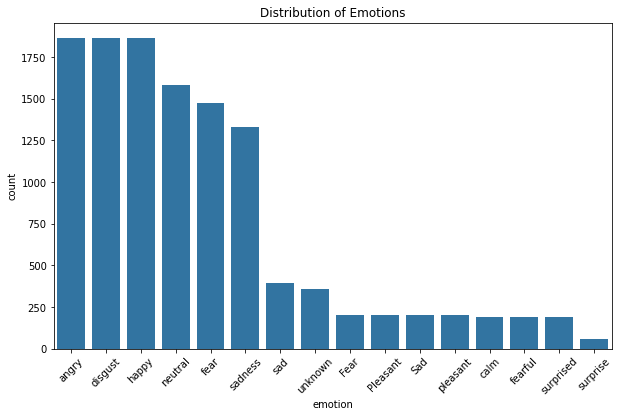

In [16]:
# distribution of emotions
plt.figure(figsize=(10, 6))
sns.countplot(data=clean_data, x='emotion', order=clean_data['emotion'].value_counts().index)
plt.title('Distribution of Emotions')
plt.xticks(rotation=45)
plt.show()

# this chart shows some a significant imbalance in the dataset. lets do some resampling
# Lets try using the SMOTE technique (Synthetic Minority Over-sampling):

In [18]:
# Lets combine columns that should be the same, such as 'Sad', 'sad', and 'sadness':

clean_data['emotion'] = clean_data['emotion'].str.lower()  # Convert to lowercase

# Replace specific values
clean_data['emotion'] = clean_data['emotion'].replace({
    'surprised': 'surprise',  # Change 'surprised' to 'surprise'
    'sadness': 'sad',          # Combine 'sadness', 'sad', 'Sad' to 'sad'
    'sad': 'sad',
    'sadness': 'sad',
    'pleasant': 'pleasant',
    'fear': 'fear',
    'fearful': 'fear',
})

# Check unique values after standardization
unique_emotions = clean_data['emotion'].unique()
print(unique_emotions)

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'pleasant' 'unknown'
 'surprise' 'calm']


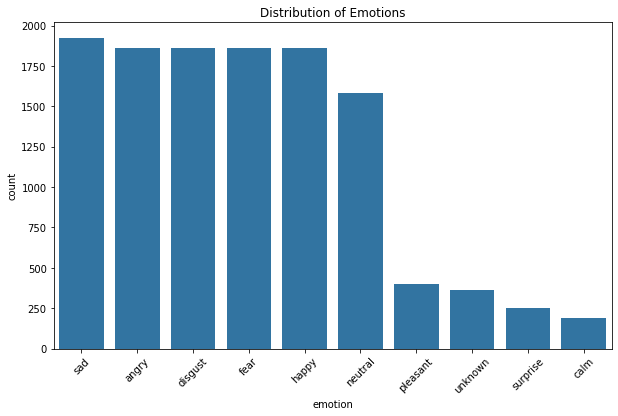

In [19]:
plt.figure(figsize=(10, 6))
sns.countplot(data=clean_data, x='emotion', order=clean_data['emotion'].value_counts().index)
plt.title('Distribution of Emotions')
plt.xticks(rotation=45)
plt.show()

# this chart shows some a significant imbalance in the dataset.
# lets reduce the higher classes like sad, angry, dusgust and so on to 1500, 
# then use augmented audio for underrepresented classes, bringing them also to 1500. 

## Harmonizing sample sizes for target

### Building a Model

In [66]:
eval_clean_data = clean_data.copy()

# Prepare the data
X = eval_clean_data.drop(columns=['emotion', 'filename', 'path'])
y = eval_clean_data['emotion']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify the original distribution of the training data
print("Original dataset shape:", Counter(y_train))

# Convert columns with object type to their means
for col in ['mfccs_mean', 'spectral_centroid', 'chroma', 'zero_crossing_rate', 'rms']:
    X_train[col] = X_train[col].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) else x)
    X_test[col] = X_test[col].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) else x)

# Check if the columns were converted correctly
print(X_train.dtypes)
# Should all be floats!

Original dataset shape: Counter({'sad': 1544, 'fear': 1502, 'angry': 1498, 'happy': 1495, 'disgust': 1457, 'neutral': 1254, 'pleasant': 331, 'unknown': 281, 'surprise': 214, 'calm': 153})
mfccs_mean            float64
spectral_centroid     float64
chroma                float64
zero_crossing_rate    float64
rms                   float64
pitch                 float64
dtype: object


In [67]:
# handle null values
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Convert object columns to float
for col in ['mfccs_mean', 'spectral_centroid', 'chroma', 'zero_crossing_rate', 'rms']:
    eval_clean_data[col] = pd.to_numeric(eval_clean_data[col], errors='coerce')

# Check for any NaN values after conversion
print(eval_clean_data.isnull().sum())

eval_clean_data = eval_clean_data.dropna()

print()

# Verify that there are no more NaN values
print(eval_clean_data.isnull().sum())


X_train shape: (9729, 6)
y_train shape: (9729,)
X_test shape: (2433, 6)
y_test shape: (2433,)
mfccs_mean            0
spectral_centroid     0
chroma                0
zero_crossing_rate    0
rms                   0
pitch                 0
path                  0
filename              0
emotion               0
dtype: int64

mfccs_mean            0
spectral_centroid     0
chroma                0
zero_crossing_rate    0
rms                   0
pitch                 0
path                  0
filename              0
emotion               0
dtype: int64


In [68]:
# Define the parameter grid and run grid search
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None] 
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           scoring='accuracy',
                           verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Review the best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

print() # new line for seperation

# evaluate the best model
best_model = grid_search.best_estimator_
y_pred_best_tree = best_model.predict(X_test)

print("Decision Tree Accuracy (Best):", accuracy_score(y_test, y_pred_best_tree))
print("Confusion Matrix (Best):\n", confusion_matrix(y_test, y_pred_best_tree))
print("Classification Report (Best):\n", classification_report(y_test, y_pred_best_tree))


Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best parameters found:  {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best cross-validation score:  0.4478363633001054

Decision Tree Accuracy (Best): 0.4619810933004521
Confusion Matrix (Best):
 [[242   0  20  28  50  12   2   8   3   0]
 [  0  21   6   1   1   3   0   6   1   0]
 [ 49   1 142  13  53  79   7  57   5   0]
 [ 71   0  38  74  47  56   3  69   3   0]
 [ 99   2  28  31 139  45   2  11  11   0]
 [ 13   8  28  12  20 169   2  76   1   0]
 [  4   0  10   4   3   2  46   0   0   0]
 [  3   5  37  23  18  70   1 215   2   5]
 [  3   2   7   1   8   0   0   2  10   5]
 [  0   0   0   0   0   0   0   9   4  66]]
Classification Report (Best):
               precision    recall  f1-score   support

       angry       0.50      0.66      0.57       365
        calm       0.54      0.54      0.54        39
     disgust       0.45      0.35      0.39       406
        fear       0

#### Evaluation:
Accuracy of 46% is not great. 

Additionally, our f1-scores don't look super hot either. Let's address this!

## Audio Augmentation for Underrepresented Classes

Let's attempt to make the model better by evening the distribution. To do this, we will lower the more represented classes to 1500 each, and create synthetic data for the underrepresented classes. 

In [69]:
reduced_data = clean_data.copy()

# drop rows with 'unknown' emotion
reduced_data = reduced_data[reduced_data['emotion'] != 'unknown']
# Define the target count for high emotion classes
target_count_high = 1500

# Loop through each emotion class and reduce to target count if above it
for emotion in reduced_data['emotion'].value_counts().index:
    current_count = reduced_data[reduced_data['emotion'] == emotion].shape[0]
    
    if current_count > target_count_high:
        # Randomly sample to reduce to the target count
        emotion_samples = reduced_data[reduced_data['emotion'] == emotion]
        reduced_samples = emotion_samples.sample(n=target_count_high, random_state=42)
        reduced_data = reduced_data[reduced_data['emotion'] != emotion]  # Remove excess samples
        reduced_data = pd.concat([reduced_data, reduced_samples], ignore_index=True)

# Check the new distribution of the reduced data
print(reduced_data['emotion'].value_counts())

emotion
sad         1500
angry       1500
disgust     1500
fear        1500
happy       1500
neutral     1500
pleasant     400
surprise     252
calm         192
Name: count, dtype: int64


In [70]:
# audio augmentation to help with uneven data
def augment_audio(data, sr):
    # Add noise
    noise = np.random.randn(len(data))
    data_with_noise = data + 0.005 * noise
    
    # Time Stretching (without altering the pitch)
    stretched_data = librosa.effects.time_stretch(data, rate=1.1)  # Slightly faster
    
    # Shifting (without altering the pitch)
    shift = np.random.randint(sr)
    shifted_data = np.roll(data, shift)
    
    # Volume adjustment
    amplitude_scale = np.random.uniform(low=0.8, high=1.2)
    adjusted_volume_data = data * amplitude_scale

    # Randomly choose one of the augmentation methods to apply
    augmentation_methods = [data_with_noise, stretched_data, shifted_data, adjusted_volume_data]
    
    augmented_data = random.choice(augmentation_methods)
    
    return augmented_data

In [71]:
# Create a new DataFrame for augmented data
augmented_data = reduced_data.copy()

# Lists to store augmented features
augmented_mfccs_mean_list = []
augmented_spectral_centroid_list = []
augmented_chroma_list = []
augmented_zero_crossing_rate_list = []
augmented_rms_list = []
augmented_pitch_list = []
augmented_emotions = []

# Define target count for underrepresented classes
target_count = 1500
underrepresented_emotions = ['pleasant', 'surprise', 'calm']

# Process and augment underrepresented emotions
for emotion in underrepresented_emotions:
    current_count = augmented_data[augmented_data['emotion'] == emotion].shape[0]
    num_augments_needed = target_count - current_count

    if num_augments_needed > 0:
        # Find all samples of this emotion in the dataset
        emotion_samples = augmented_data[augmented_data['emotion'] == emotion]
        
        # Augment samples until we reach the target count
        for _ in range(num_augments_needed):
            # Randomly select a sample to augment
            random_sample = emotion_samples.sample(n=1).iloc[0]
            audio_file = os.path.join(random_sample['path'], random_sample['filename'])
            
            try:
                # Load the audio file
                data, sr = librosa.load(audio_file, sr=None)

                # Perform augmentation
                augmented_data_sample = augment_audio(data, sr)

                # Extract features from the augmented audio
                augmented_features = extract_features(augmented_data_sample, sr=sr, from_file=False)

                # Append augmented features to lists
                augmented_mfccs_mean_list.append(augmented_features[0])
                augmented_spectral_centroid_list.append(augmented_features[1])
                augmented_chroma_list.append(augmented_features[2])
                augmented_zero_crossing_rate_list.append(augmented_features[3])
                augmented_rms_list.append(augmented_features[4])
                augmented_pitch_list.append(augmented_features[5])
                augmented_emotions.append(emotion)

            except Exception as e:
                print(f"Error processing {audio_file}: {str(e)}")

# After augmentation, create a DataFrame to store augmented features
augmented_df = pd.DataFrame({
    'mfccs_mean': augmented_mfccs_mean_list,
    'spectral_centroid': augmented_spectral_centroid_list,
    'chroma': augmented_chroma_list,
    'zero_crossing_rate': augmented_zero_crossing_rate_list,
    'rms': augmented_rms_list,
    'pitch': augmented_pitch_list,
    'emotion': augmented_emotions
})

# Combine reduced data with augmented data
eval_aug_data = pd.concat([reduced_data, augmented_df], ignore_index=True)

# Check the final distribution
print(eval_aug_data['emotion'].value_counts())


emotion
pleasant    1500
surprise    1500
calm        1500
sad         1500
angry       1500
disgust     1500
fear        1500
happy       1500
neutral     1500
Name: count, dtype: int64


### New Model for the New Data

Now, lets do build another model and evaulate it's accuracy, given our now-evenly-distributed data. 

In [72]:
# Drop non-numeric columns like 'id', 'filename', 'path' before fitting the model
X = eval_aug_data.drop(columns=['emotion', 'filename', 'path'])  # drop any non-numeric columns
y = eval_aug_data['emotion']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert columns with object type to their means (if they're lists or arrays)
for col in ['mfccs_mean', 'spectral_centroid', 'chroma', 'zero_crossing_rate', 'rms']:
    X_train[col] = X_train[col].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) else x)
    X_test[col] = X_test[col].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) else x)


# Check if the columns were converted correctly
print(X_train.dtypes)


mfccs_mean            float64
spectral_centroid     float64
chroma                float64
zero_crossing_rate    float64
rms                   float64
pitch                 float64
dtype: object


In [73]:
# handle null values
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Convert object columns to float
for col in ['mfccs_mean', 'spectral_centroid', 'chroma', 'zero_crossing_rate', 'rms']:
    eval_aug_data[col] = pd.to_numeric(eval_aug_data[col], errors='coerce')

# Check for any NaN values after conversion
print(eval_aug_data.isnull().sum())

eval_aug_data = eval_aug_data.dropna()

print()

# Verify that there are no more NaN values
print(eval_aug_data.isnull().sum())


X_train shape: (10800, 6)
y_train shape: (10800,)
X_test shape: (2700, 6)
y_test shape: (2700,)
mfccs_mean            3656
spectral_centroid     3656
chroma                3656
zero_crossing_rate    3656
rms                   3656
pitch                    0
path                  3656
filename              3656
emotion                  0
dtype: int64

mfccs_mean            0
spectral_centroid     0
chroma                0
zero_crossing_rate    0
rms                   0
pitch                 0
path                  0
filename              0
emotion               0
dtype: int64


In [74]:
# Define the parameter grid and run grid search
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None] 
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           scoring='accuracy',
                           verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Review the best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

print() # new line for seperation

# evaluate the best model
best_model = grid_search.best_estimator_
y_pred_best_tree = best_model.predict(X_test)

print("Decision Tree Accuracy (Best):", accuracy_score(y_test, y_pred_best_tree))
print("Confusion Matrix (Best):\n", confusion_matrix(y_test, y_pred_best_tree))
print("Classification Report (Best):\n", classification_report(y_test, y_pred_best_tree))


Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best parameters found:  {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation score:  0.564537037037037

Decision Tree Accuracy (Best): 0.575925925925926
Confusion Matrix (Best):
 [[192   4  13  18  54  12   6   2   9]
 [  0 289   0   3   0   1   0   0  18]
 [ 16  13  89   9  27  60  23  28  20]
 [ 39   4  36  51  38  50   6  57  18]
 [ 54   2  15   7  90  65  21  11  19]
 [  7  15  45   5  16 185   3  49   6]
 [  3   0  24   1   3   1 264   3   0]
 [  7  14  37  14  11  63   3 140   8]
 [  1  21   1   0   2   3   1   0 255]]
Classification Report (Best):
               precision    recall  f1-score   support

       angry       0.60      0.62      0.61       310
        calm       0.80      0.93      0.86       311
     disgust       0.34      0.31      0.33       285
        fear       0.47      0.17      0.25       299
       happy       0.37      0.32      0.34     

#### Evaluation:
Accuracy of 58%; certainly an imporovement! But nothing substantial. 

Despite evening the distribution, we are still not seeing the model perform well. This is likely because 7k records
is probably not enough to get good predictive capacity over our 7 categories. 

Let's engineer the categories into pos/neg binary classification and see if that improves our results.

In [ ]:
Merge Datasets: done!
Extract Features: done!
Scale Data: done
Clean Data: done!
SMOTE for underrepresentation: no improvement 
Augment Data: no improvement
Feature Selection: no improvement
